In [289]:
import datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf
import plotnine as p9
import statsmodels.formula.api as smf

import plotnine as p9
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [290]:
"""
Ticker  Fund Name                           Issuer                          AUM         Expense Ratio       3-Mo TR     Segment
MSTU	T-Rex 2X Long MSTR Daily Target ETF	Tuttle Capital Management LLC	$850.96M	1.05%	            -68.3%	    Leveraged Equity: U.S. Application Software
""";

In [291]:
# tickers = ['MSTU', 'MSTR']
# ydata = yf.Tickers(tickers).download(period="max", auto_adjust=True, interval="1h")['Close']

In [292]:
# ydata.head()

In [293]:
# data = (   # put data in long form
#     ydata
#     .dropna()
#     .stack(future_stack=True)  # Removed the level parameter since there's only one level
#     .reset_index()
#     .rename(columns={0: 'Close'})  # Rename the stacked column to 'Close'
#     [['Datetime', 'Ticker', 'Close']]  # Note: column is 'Datetime', not 'Date', because of interval="1h"
#     .sort_values(by=['Datetime', 'Ticker'])
# )

# data.head(5)

In [294]:
# # time period is the min datetime of data df, converted to string in format YYYY-MM-DD
# time_period = data['Datetime'].min()

# # keep only date from time_period
# time_period = time_period.date().strftime('%Y-%m-%d')

# print(time_period)

In [295]:
# # download historical data from Yahoo Finance to csv, file name data_<tickers>_2002-07-30_D.csv
# data.to_csv('data_MSTU_MSTR_' + time_period + '_D.csv', index=False)

In [296]:
time_period = "2024-09-18"

In [297]:
# read data from csv
data = pd.read_csv('data_MSTU_MSTR_' + time_period + '_D.csv')
data['Datetime'] = pd.to_datetime(data['Datetime'])
print(data.info())
print(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994 entries, 0 to 3993
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   Datetime  3994 non-null   datetime64[ns, UTC]
 1   Ticker    3994 non-null   object             
 2   Close     3994 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 93.7+ KB
None
                   Datetime Ticker       Close
0 2024-09-18 13:30:00+00:00   MSTR  130.410004
1 2024-09-18 13:30:00+00:00   MSTU    2.415000
2 2024-09-18 14:30:00+00:00   MSTR  131.684998
3 2024-09-18 14:30:00+00:00   MSTU    2.496000
4 2024-09-18 15:30:00+00:00   MSTR  132.600006


In [298]:
# rename Datetime to Date, to keep consistent with previous notebooks
data = data.rename(columns={'Datetime': 'Date'})

In [299]:
# Add year-month label (end of month date)

# Convert Date column to datetime type
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column 'ym' representing the last day of each month
data['ym'] = data['Date'] + pd.offsets.MonthEnd(0)

# keep only date for column ym
data['ym'] = data['ym'].dt.date

data.head()

,Date,Ticker,Close,ym
0,2024-09-18 13:30:00+00:00,MSTR,130.410004,2024-09-30
1,2024-09-18 13:30:00+00:00,MSTU,2.415000,2024-09-30
2,2024-09-18 14:30:00+00:00,MSTR,131.684998,2024-09-30
3,2024-09-18 14:30:00+00:00,MSTU,2.496000,2024-09-30
4,2024-09-18 15:30:00+00:00,MSTR,132.600006,2024-09-30


In [300]:
"""
df starts from 2024-09-18

In the next cell, this will be marked as td = 1, but actually it td = 12.

Due to this, in the next cell, I introduced a filter to keep data from a full month, 2024-10-01 onwards.
""";

In [301]:
# Create trading-day counter for each Ticker and month

# Sort data to ensure correct order
data = data.sort_values(['Ticker', 'Date']).copy()

# Keep data from October 2024 onwards - make timestamp timezone-aware
data = data[data['Date'] >= pd.Timestamp(2024, 10, 1, tz='UTC')]

# Count trading days within each (Ticker, ym) group
data['td'] = data.groupby(['Ticker', 'ym']).cumcount() + 1

# # add data['td'] column where td is the day of the month for each Ticker
# data['td'] = data['Date'].dt.day

data.head()

,Date,Ticker,Close,ym,td
126,2024-10-01 13:30:00+00:00,MSTR,163.210007,2024-10-31,1
128,2024-10-01 14:30:00+00:00,MSTR,158.889999,2024-10-31,2
130,2024-10-01 15:30:00+00:00,MSTR,161.259995,2024-10-31,3
132,2024-10-01 16:30:00+00:00,MSTR,158.470001,2024-10-31,4
134,2024-10-01 17:30:00+00:00,MSTR,164.660004,2024-10-31,5


In [302]:
#  Calculate daily simple returns

# Calculate percentage change of 'Close' within each ticker
data['ret'] = data.groupby('Ticker')['Close'].pct_change()

# fill na values in ret with 0
data['ret'] = data['ret'].fillna(0)

data.head()

,Date,Ticker,Close,ym,td,ret
126,2024-10-01 13:30:00+00:00,MSTR,163.210007,2024-10-31,1,0.000000
128,2024-10-01 14:30:00+00:00,MSTR,158.889999,2024-10-31,2,-0.026469
130,2024-10-01 15:30:00+00:00,MSTR,161.259995,2024-10-31,3,0.014916
132,2024-10-01 16:30:00+00:00,MSTR,158.470001,2024-10-31,4,-0.017301
134,2024-10-01 17:30:00+00:00,MSTR,164.660004,2024-10-31,5,0.039061


In [303]:
# Filter dates and keep only needed columns

# Keep only useful columns
data = data[['Date', 'ym', 'Ticker', 'Close', 'ret', 'td']]

data.head()

,Date,ym,Ticker,Close,ret,td
126,2024-10-01 13:30:00+00:00,2024-10-31,MSTR,163.210007,0.000000,1
128,2024-10-01 14:30:00+00:00,2024-10-31,MSTR,158.889999,-0.026469,2
130,2024-10-01 15:30:00+00:00,2024-10-31,MSTR,161.259995,0.014916,3
132,2024-10-01 16:30:00+00:00,2024-10-31,MSTR,158.470001,-0.017301,4
134,2024-10-01 17:30:00+00:00,2024-10-31,MSTR,164.660004,0.039061,5


In [304]:
# Create start/end/month flags and conditional returns

N = 15  # number of days for start of month
M = 5   # number of days for next start of month

# Flags: 1 if condition true, 0 otherwise
data['som_flag'] = (data['td'] <= N).astype(int)
data['eom_flag'] = (data['td'] > N).astype(int)
data['nsm_flag'] = (data['td'] <= M).astype(int)

# Conditional returns (return only within flag period)
data['ret_som'] = data['ret'] * data['som_flag']
data['ret_eom'] = data['ret'] * data['eom_flag']
data['ret_nsm'] = data['ret'] * data['nsm_flag']

data.head()

,Date,ym,Ticker,Close,ret,td,som_flag,eom_flag,nsm_flag,ret_som,ret_eom,ret_nsm
126,2024-10-01 13:30:00+00:00,2024-10-31,MSTR,163.210007,0.000000,1,1,0,1,0.000000,0.0,0.000000
128,2024-10-01 14:30:00+00:00,2024-10-31,MSTR,158.889999,-0.026469,2,1,0,1,-0.026469,-0.0,-0.026469
130,2024-10-01 15:30:00+00:00,2024-10-31,MSTR,161.259995,0.014916,3,1,0,1,0.014916,0.0,0.014916
132,2024-10-01 16:30:00+00:00,2024-10-31,MSTR,158.470001,-0.017301,4,1,0,1,-0.017301,-0.0,-0.017301
134,2024-10-01 17:30:00+00:00,2024-10-31,MSTR,164.660004,0.039061,5,1,0,1,0.039061,0.0,0.039061


In [305]:
# Keep only relevant return columns
data_flags = data[['Date', 'ym', 'Ticker', 'ret_som', 'ret_eom', 'ret_nsm']]

data_flags.head()

,Date,ym,Ticker,ret_som,ret_eom,ret_nsm
126,2024-10-01 13:30:00+00:00,2024-10-31,MSTR,0.000000,0.0,0.000000
128,2024-10-01 14:30:00+00:00,2024-10-31,MSTR,-0.026469,-0.0,-0.026469
130,2024-10-01 15:30:00+00:00,2024-10-31,MSTR,0.014916,0.0,0.014916
132,2024-10-01 16:30:00+00:00,2024-10-31,MSTR,-0.017301,-0.0,-0.017301
134,2024-10-01 17:30:00+00:00,2024-10-31,MSTR,0.039061,0.0,0.039061


In [306]:
# Pivot to wide format (one column per Ticker)

# Create wide format table: columns for each Ticker and return type
pivoted = data_flags.pivot(index=['Date', 'ym'], columns='Ticker')

# Flatten multi-level column names (e.g. ret_som_MSTU)
pivoted.columns = [f"{col[1]}_{col[0]}" for col in pivoted.columns]

pivoted = pivoted.reset_index()

# count of nan values in each column
nan = pivoted.isna().sum()
print(nan)

# fill missing values with 0
pivoted = pivoted.fillna(0)

pivoted.head()

Date            0
ym              0
MSTR_ret_som    0
MSTU_ret_som    0
MSTR_ret_eom    0
MSTU_ret_eom    0
MSTR_ret_nsm    0
MSTU_ret_nsm    0
dtype: int64


,Date,ym,MSTR_ret_som,MSTU_ret_som,MSTR_ret_eom,MSTU_ret_eom,MSTR_ret_nsm,MSTU_ret_nsm
0,2024-10-01 13:30:00+00:00,2024-10-31,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,2024-10-01 14:30:00+00:00,2024-10-31,-0.026469,-0.059475,-0.0,-0.0,-0.026469,-0.059475
2,2024-10-01 15:30:00+00:00,2024-10-31,0.014916,0.034630,0.0,0.0,0.014916,0.034630
3,2024-10-01 16:30:00+00:00,2024-10-31,-0.017301,-0.034766,-0.0,-0.0,-0.017301,-0.034766
4,2024-10-01 17:30:00+00:00,2024-10-31,0.039061,0.082686,0.0,0.0,0.039061,0.082686


In [307]:
# create a copy of data to be later used for the backtest analysis (8 PL streams in the backtesting)
hours = pivoted.copy()

In [308]:
# Compute relative returns and aggregate monthly

# Calculate combined and relative returns
pivoted['MSTU_ret'] = pivoted['MSTU_ret_som'] + pivoted['MSTU_ret_eom']
pivoted['MSTU_MSTR_som'] = pivoted['MSTU_ret_som'] - pivoted['MSTR_ret_som']
pivoted['MSTU_MSTR_eom'] = pivoted['MSTU_ret_eom'] - pivoted['MSTR_ret_eom']
pivoted['MSTU_MSTR_nsm'] = pivoted['MSTU_ret_nsm'] - pivoted['MSTR_ret_nsm']

# Add MSTR returns to pivoted
pivoted['MSTR_ret'] = pivoted['MSTR_ret_som'] + pivoted['MSTR_ret_eom']

# Select relevant columns
returns = pivoted[['ym', 'MSTU_ret', 'MSTR_ret', 'MSTU_MSTR_som', 'MSTU_MSTR_eom', 'MSTU_MSTR_nsm']]

# Aggregate monthly returns using compounding formula
monthly = returns.groupby('ym').apply(lambda x: (1 + x).prod() - 1)

monthly.head()

,MSTU_ret,MSTR_ret,MSTU_MSTR_som,MSTU_MSTR_eom,MSTU_MSTR_nsm
ym,,,,,
2024-10-31,1.043420,0.497580,-0.004123,0.449022,0.011101
2024-11-30,1.065832,0.579167,-0.040338,0.535675,-0.067372
2024-12-31,-0.522307,-0.249132,-0.059627,-0.276926,-0.052570
2025-01-31,0.211361,0.153026,0.235731,-0.097609,0.027472
2025-02-28,-0.459106,-0.235112,0.034416,-0.282813,0.024501


In [309]:
monthly.tail(5)

,MSTU_ret,MSTR_ret,MSTU_MSTR_som,MSTU_MSTR_eom,MSTU_MSTR_nsm
ym,,,,,
2025-07-31,-0.059908,-0.006136,0.004785,-0.042780,-0.060427
2025-08-31,-0.355392,-0.168604,-0.065894,-0.151526,-0.081719
2025-09-30,-0.115304,-0.035332,-0.046367,-0.020249,0.015710
2025-10-31,-0.352101,-0.162487,0.072745,-0.256166,0.044530
2025-11-30,-0.211111,-0.103287,-0.069149,-0.047171,-0.015873


In [310]:
return_data = monthly.copy()

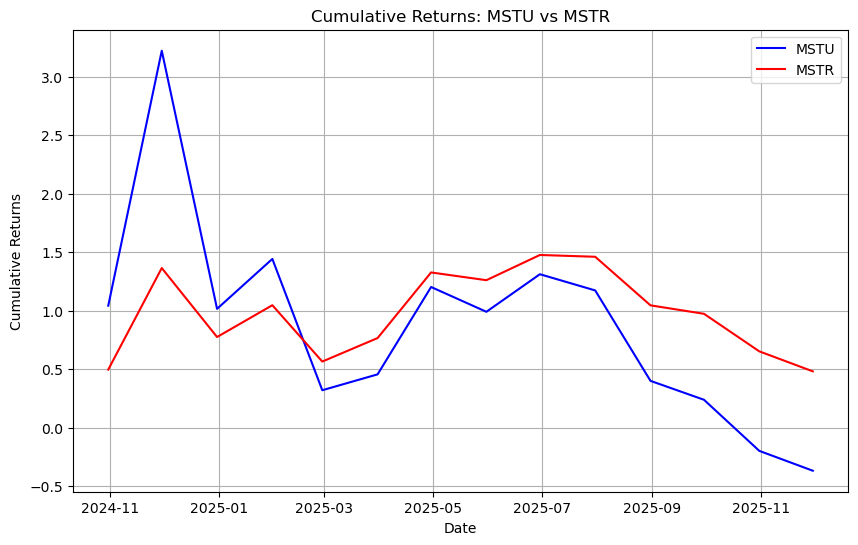

In [311]:
# calculate cumulative returns for MSTU_ret and MSTR_ret
monthly['MSTU_cumret'] = (1 + monthly['MSTU_ret']).cumprod() - 1
monthly['MSTR_cumret'] = (1 + monthly['MSTR_ret']).cumprod() - 1

# plot MSTU_ret vs MSTR_ret to compare their performance
plt.figure(figsize=(10, 6))
plt.plot(monthly.index, monthly['MSTU_cumret'], label='MSTU', color='blue')
plt.plot(monthly.index, monthly['MSTR_cumret'], label='MSTR', color='red')
plt.title('Cumulative Returns: MSTU vs MSTR')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()

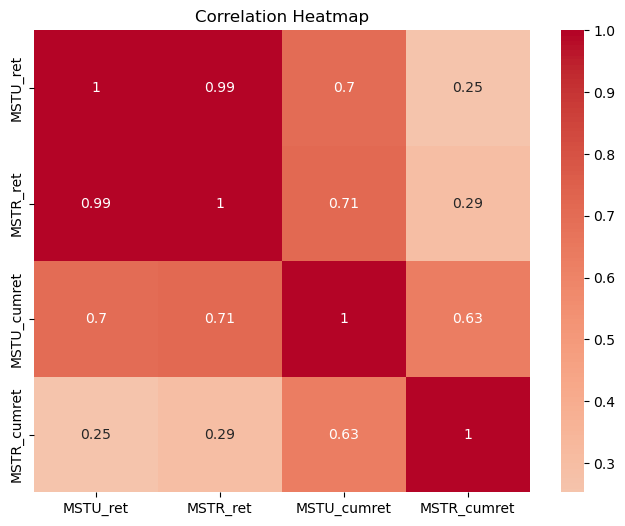

In [312]:
# plot correlation heatmap of MSTU_ret, MSTR_ret, MSTU_cumret, MSTR_cumret
plt.figure(figsize=(8, 6))
sns.heatmap(monthly[['MSTU_ret', 'MSTR_ret', 'MSTU_cumret', 'MSTR_cumret']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

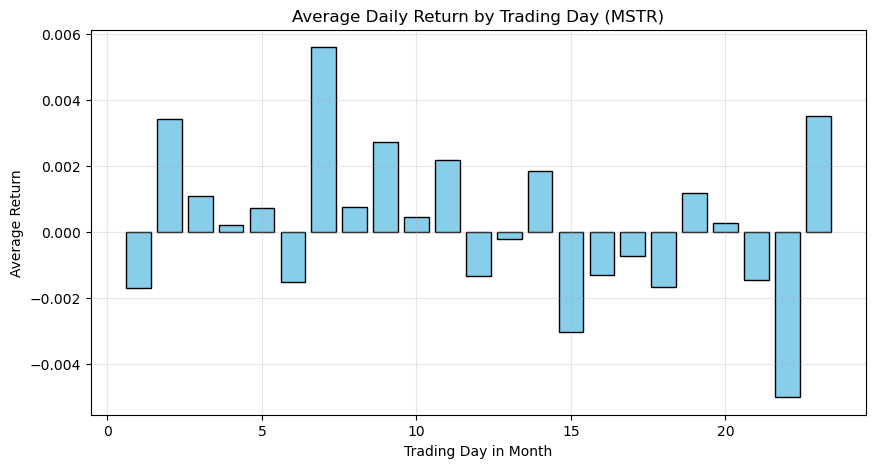

,td,ret
18,19,0.001177
19,20,0.000263
20,21,-0.001443
21,22,-0.005011
22,23,0.003524


In [313]:
# Average daily returns of MSTR and MSTU
# Keep only rows where the ticker is 'MSTR' 
MSTR = data[data['Ticker'] == 'MSTR'].copy()

# Add 'ym' column as the end of the month for each date 
MSTR['ym'] = MSTR['Date'] + pd.offsets.MonthEnd(0)

# Calculate daily return based on the Close price 
MSTR['ret'] = MSTR['Close'].pct_change()

MSTR_filtered = MSTR.copy()

# For each month, number the days starting from 1 
MSTR_filtered['td'] = MSTR_filtered.groupby('ym').cumcount() + 1

# Group by the trading day number and take the mean of returns 
avg_daily_returns = MSTR_filtered.groupby('td')['ret'].mean().reset_index()

# Plot average daily returns using matplotlib 
plt.figure(figsize=(10, 5))
plt.bar(avg_daily_returns['td'], avg_daily_returns['ret'], color='skyblue', edgecolor='black')

# Add labels and title 
plt.title("Average Daily Return by Trading Day (MSTR)")
plt.xlabel("Trading Day in Month")
plt.ylabel("Average Return")
plt.grid(alpha=0.3)

plt.show()

# Show the last few rows of the data for reference 
avg_daily_returns.tail()

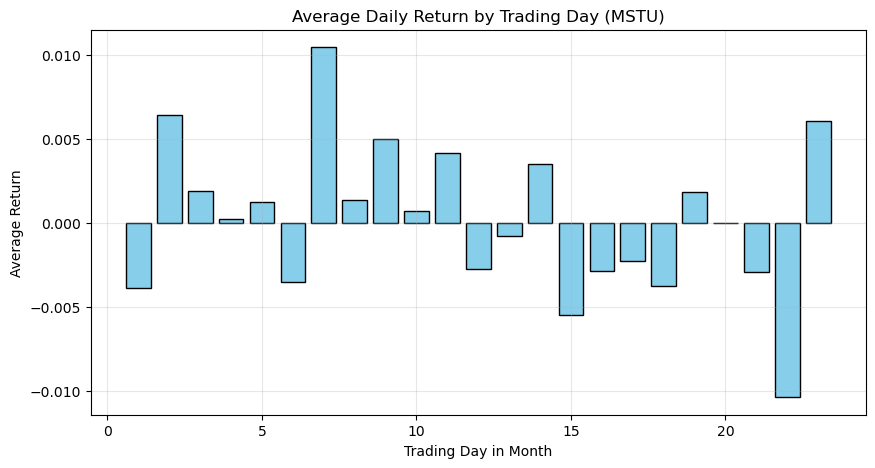

,td,ret
18,19,0.001861
19,20,-0.000022
20,21,-0.002909
21,22,-0.010349
22,23,0.006068


In [314]:
# Keep only rows where the ticker is 'MSTU'
MSTU = data[data['Ticker'] == 'MSTU'].copy()

# Add 'ym' column as the end of the month for each date
MSTU['ym'] = MSTU['Date'] + pd.offsets.MonthEnd(0)

# Calculate daily return based on the Close price
MSTU['ret'] = MSTU['Close'].pct_change()

# Keep only data after 1st August 2002
MSTU_filtered = MSTU[MSTU['Date'] >= pd.Timestamp(2024, 10, 1, tz='UTC')].copy()

# For each month, number the days starting from 1
MSTU_filtered['td'] = MSTU_filtered.groupby('ym').cumcount() + 1

# Group by the trading day number and take the mean of returns
avg_daily_returns_MSTU = MSTU_filtered.groupby('td')['ret'].mean().reset_index()

# Plot average daily returns using matplotlib
plt.figure(figsize=(10, 5))
plt.bar(avg_daily_returns_MSTU['td'], avg_daily_returns_MSTU['ret'], color='skyblue', edgecolor='black')

# Add labels and title
plt.title("Average Daily Return by Trading Day (MSTU)")
plt.xlabel("Trading Day in Month")
plt.ylabel("Average Return")
plt.grid(alpha=0.3)

plt.show()

# Show the last few rows of the data for reference
avg_daily_returns_MSTU.tail()